In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=31

In [2]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

### Read data and dpca

In [80]:
X_fr = from_python_hdf5('C:/Users/camil/Documents/int/dPCA-master/matlab/frlip.h5')[0]['pp']

In [81]:
N=X_fr.shape[1]

In [82]:
X_fr.shape

(15, 200, 5, 1050)

In [83]:
# trial-average data
X = np.mean(X_fr,0)
# center data
#X -= np.mean(X.reshape((N,-1)),1)[:,None,None]
print(X.shape)

(200, 5, 1050)


In [84]:
dpca = dPCA.dPCA(labels='st',regularizer=0,n_components=X_fr.shape[1],n_iter=5)#
dpca.protect = ['t']
#dpca.n_trials = 3
Z = dpca.fit_transform(X,X_fr)

In [92]:
variances = dpca.get_variances(X)

In [93]:
variances.keys()

dict_keys(['cumulative_var', 'component_var', 'which_marg'])

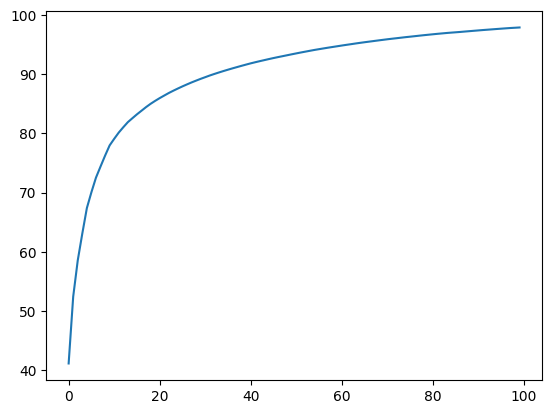

In [87]:
plt.plot(variances['cumulative_var'][:100])

In [90]:
# trial-average data
X_full = np.mean(X_fr,0)
X = X_full.reshape((N,-1))
X_cen = X- np.mean(X,1)[:,None]

# # center data
# X_avg -= np.mean(X_avg.reshape((N,-1)),1)[:,None,None]
# X_flat2d = X_avg.reshape((N,-1)).T

In [111]:
Z_full = X_cen.T@dpca.D_sorted
which_marg=variances['which_marg']
components =np.concatenate([np.where(which_marg==i)[0][:3] for i in ['st','s','t']])

In [112]:
which_marg[:10]

array(['t', 't', 's', 't', 't', 'st', 't', 'st', 's', 't'], dtype='<U2')

In [113]:
np.where(which_marg=='s')[0][:3]

array([ 2,  8, 10], dtype=int64)

In [114]:
components

array([ 5,  7, 11,  2,  8, 10,  0,  1,  3], dtype=int64)

In [115]:
X_cen.T.shape

(5250, 200)

In [98]:
X2 = np.reshape(X_full, (200, 1050 * 5))

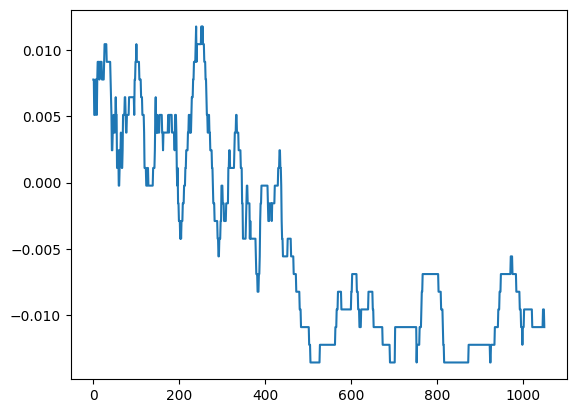

In [104]:
plt.plot(X_cen.T[:1050,0])

In [122]:
Z= Z_full.T[components].reshape(np.concatenate((components.shape,X_full.shape[1:])))
Z.shape

(9, 5, 1050)

In [130]:
comp=['st','s','t']
components

array([ 5,  7, 11,  2,  8, 10,  0,  1,  3], dtype=int64)

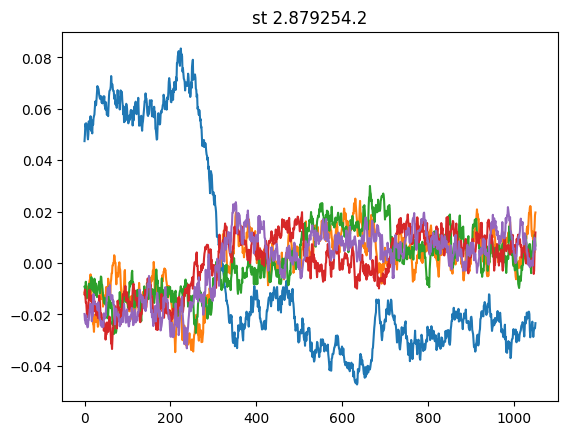

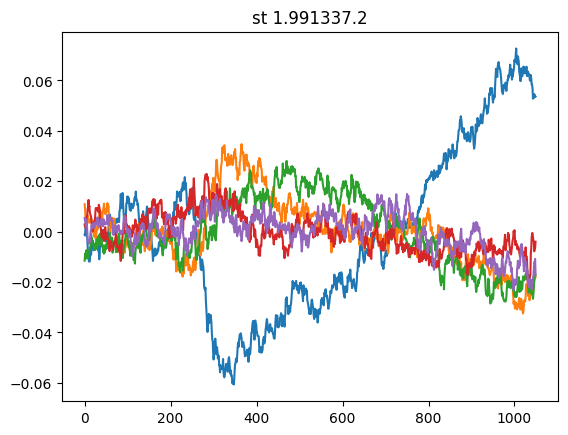

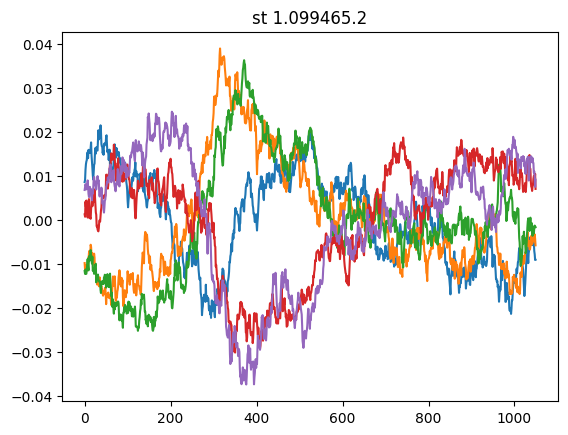

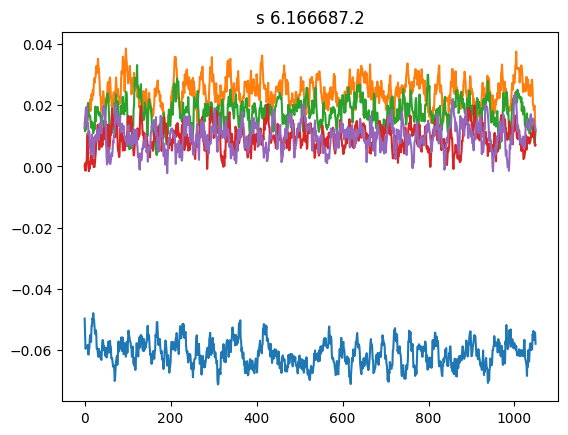

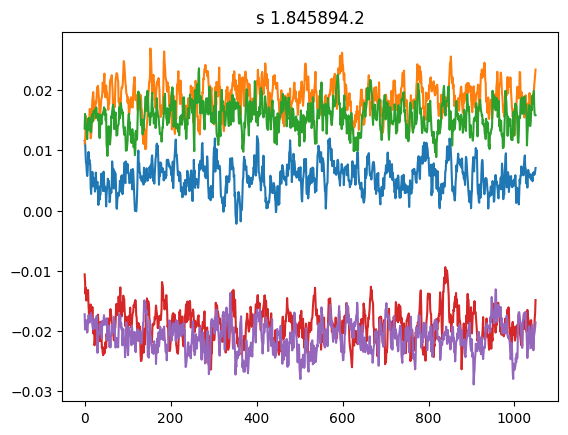

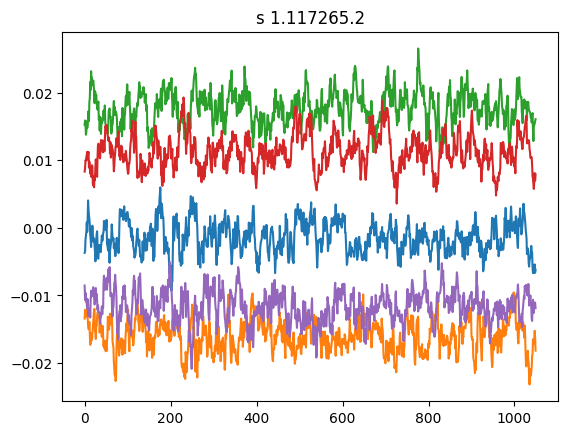

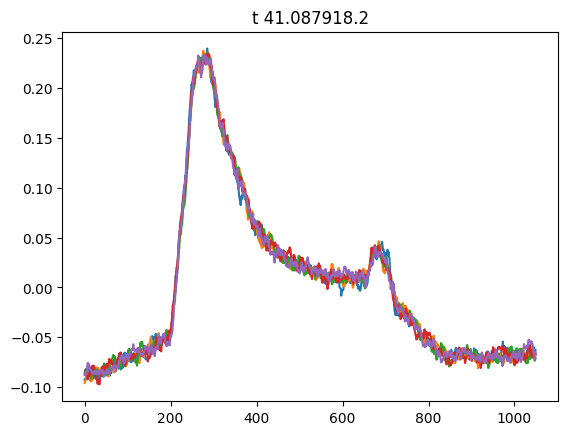

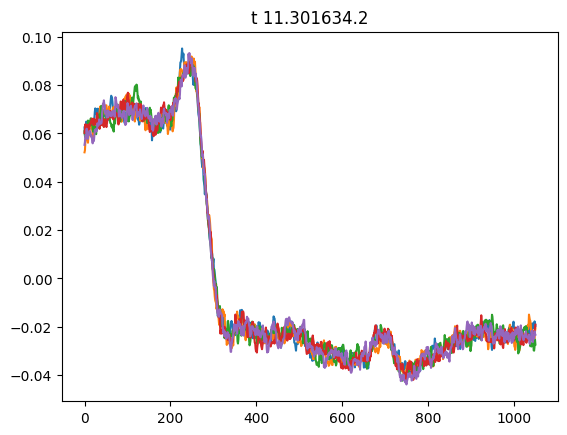

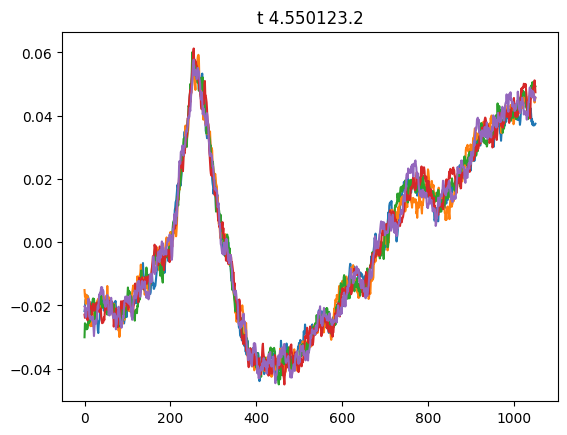

In [131]:
for i in range(Z.shape[0]):
    f,ax=plt.subplots()
    ax.plot(Z[i].T)
    ax.set(title='%s %f.2'%(which_marg[components[i]],variances['component_var'][components][i]))